# Tennis match outcome prediction

The purpose of this notebook is to explore the possibility of predicting the outcome of a tennis match based on the previous history (data available from 2013) of the two players

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict

## Dataset

I'll start by importing the data from the xlsx files; there is one file per year, so I am merging all of them in one single dataframe

In [3]:
df = pd.concat([
    pd.read_excel('data/matches/2017.xlsx'),
    pd.read_excel('data/matches/2016.xlsx'),
    pd.read_excel('data/matches/2015.xlsx'),
    pd.read_excel('data/matches/2014.xlsx'),
    pd.read_excel('data/matches/2013.xlsx')
], axis = 0)

df.head()

,ATP,AvgL,AvgW,B365L,B365W,Best of,Comment,Court,Date,EXL,...,Tournament,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
0,1,3.50,1.29,3.50,1.28,3,Completed,Outdoor,2017-01-01,3.50,...,Brisbane International,6.0,6.0,NaN,NaN,NaN,689.0,79.0,Thompson J.,2.0
1,1,2.43,1.54,2.50,1.50,3,Completed,Outdoor,2017-01-02,2.35,...,Brisbane International,4.0,6.0,6.0,NaN,NaN,1102.0,39.0,Mahut N.,2.0
2,1,1.77,2.01,1.80,1.90,3,Completed,Outdoor,2017-01-02,1.75,...,Brisbane International,6.0,7.0,NaN,NaN,NaN,1785.0,21.0,Ferrer D.,2.0
3,1,3.01,1.37,3.00,1.36,3,Completed,Outdoor,2017-01-02,2.75,...,Brisbane International,7.0,7.0,NaN,NaN,NaN,1001.0,45.0,Edmund K.,2.0
4,1,2.85,1.41,2.75,1.40,3,Completed,Outdoor,2017-01-02,2.65,...,Brisbane International,6.0,6.0,NaN,NaN,NaN,2035.0,17.0,Dimitrov G.,2.0


What does the dataset contains?

In [4]:
df.columns

Index(['ATP', 'AvgL', 'AvgW', 'B365L', 'B365W', 'Best of', 'Comment', 'Court',
       'Date', 'EXL', 'EXW', 'L1', 'L2', 'L3', 'L4', 'L5', 'LBL', 'LBW',
       'LPts', 'LRank', 'Location', 'Loser', 'Lsets', 'MaxL', 'MaxW', 'PSL',
       'PSW', 'Round', 'SJL', 'SJW', 'Series', 'Surface', 'Tournament', 'W1',
       'W2', 'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner', 'Wsets'],
      dtype='object')

Out of curiosity, who are the most successful player in recent years?

In [5]:
df['Winner'].value_counts()[:10]

Djokovic N.     309
Nadal R.        269
Murray A.       258
Berdych T.      233
Federer R.      231
Ferrer D.       227
Nishikori K.    219
Wawrinka S.     213
Raonic M.       200
Dimitrov G.     191
Name: Winner, dtype: int64

## Prediction
### Data exploration

Let's take a look at the match history for Nadal vs. Djokovic and let's use historical data to build the dataset and try to predict the outcome of a match

In [6]:
history = pd.concat([
    df[(df['Winner'] == 'Djokovic N.') | (df['Winner'] == 'Nadal R.')],
    df[(df['Loser'] == 'Djokovic N.') | (df['Loser'] == 'Nadal R.')]
])

print(history.shape)

history.head()

(677, 42)


,ATP,AvgL,AvgW,B365L,B365W,Best of,Comment,Court,Date,EXL,...,Tournament,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
11,1,5.34,1.14,5.0,1.16,3,Completed,Outdoor,2017-01-03,4.30,...,Brisbane International,6.0,6.0,NaN,NaN,NaN,3300.0,9.0,Nadal R.,2.0
19,1,6.16,1.11,6.0,1.12,3,Completed,Outdoor,2017-01-05,5.25,...,Brisbane International,6.0,6.0,NaN,NaN,NaN,3300.0,9.0,Nadal R.,2.0
57,3,12.47,1.03,15.0,1.03,3,Completed,Outdoor,2017-01-02,7.75,...,Qatar Exxon Mobil Open,7.0,6.0,NaN,NaN,NaN,11780.0,2.0,Djokovic N.,2.0
74,3,16.32,1.02,19.0,1.02,3,Completed,Outdoor,2017-01-04,10.00,...,Qatar Exxon Mobil Open,6.0,6.0,NaN,NaN,NaN,11780.0,2.0,Djokovic N.,2.0
79,3,15.26,1.02,17.0,1.02,3,Completed,Outdoor,2017-01-05,8.50,...,Qatar Exxon Mobil Open,6.0,6.0,NaN,NaN,NaN,11780.0,2.0,Djokovic N.,2.0


There are 677 matches played by either Nadal or Djokovic (or both).

Let's take a deeper look at some features, starting from `Surface`

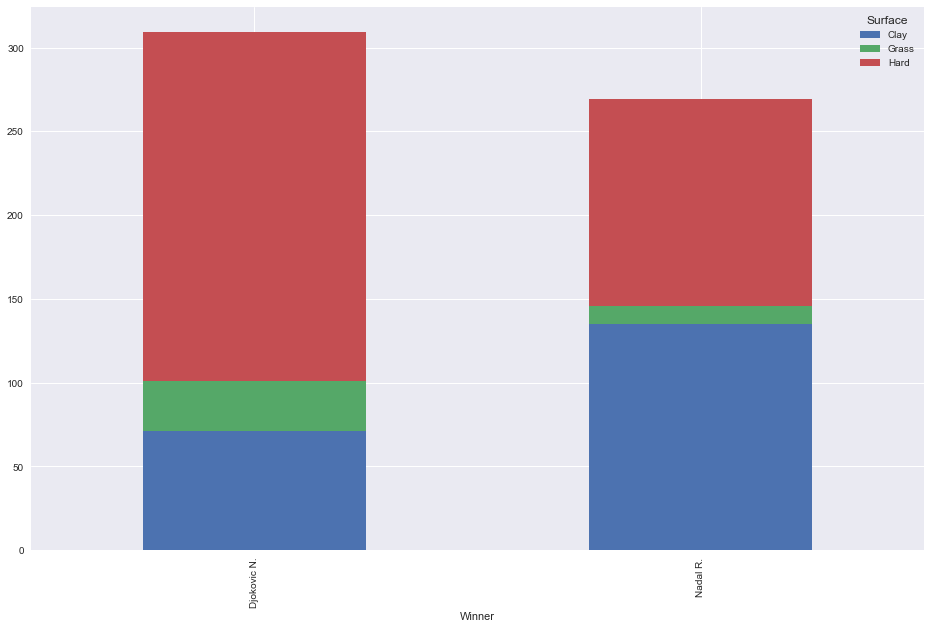

In [7]:
surface_xt = pd.crosstab(df['Winner'], df['Surface'])
target_surface = surface_xt[(surface_xt.index.values == 'Nadal R.') | (surface_xt.index.values == 'Djokovic N.')]

target_surface.plot(kind='bar', stacked=True, figsize=(16, 10));

What is the winner/loser ratio for both player?

In [8]:
len(df[df['Winner'] == 'Nadal R.'])

269

In [9]:
len(df[df['Loser'] == 'Nadal R.'])

60

In [10]:
len(df[df['Winner'] == 'Djokovic N.'])

309

In [11]:
len(df[df['Loser'] == 'Djokovic N.'])

39

### Feature engineering

My first experiment will be to approach the problem as a classification one; either player1 wins or player2 wins; in order to create a balanced dataset, I will split the available data 50:50 and assign to half of it label 0 and to the other half label 1

Outcome representation:
- 1: player 1 wins
- 0: player 2 wins

In [12]:
df_player1 = history.head(len(history)//2)
df_player2 = history.tail(len(history) - len(df_player1))

print(df_player1.shape, df_player2.shape)

(338, 42) (339, 42)


The first feature that I am augmenting is derived from the rank of the two players; I will just create a new `RankDiff` attribute, computed as the rank of player1 minus the rank of player 2

In [13]:
final_1 = pd.DataFrame()

final_1['RankDiff'] = df_player1['WRank'] - df_player1['LRank']

final_1['y'] = 1

In [14]:
final_2 = pd.DataFrame()

final_2['RankDiff'] = df_player2['LRank'] - df_player2['WRank']

final_2['y'] = 0

In [15]:
final = pd.concat([
    final_1,
    final_2
])

final.sample(5)

,RankDiff,y
2016,-15.0,0
1316,-160.0,1
533,-24.0,1
2010,79.0,0
2191,20.0,0


I want to keep information about the surface, court, location and tournament, but they are in a string format so they are not much use right now.

I will use dummies to keep the feature; dummies are basically one-hot encoding the attributes

In [16]:
final = pd.concat([
    final,
    pd.get_dummies(history['Surface']),
    pd.get_dummies(history['Court']),
    pd.get_dummies(history['Location']),
    pd.get_dummies(history['Tournament'])
], axis=1)

Another feature that I want to create is the number of days elapsed for the player since its last match. This might be an useful indicator and its the only way, in such a naive approach, to preserve some kind of temporal information

In [17]:
elapsed = pd.concat([
    df_player1['Date'] - df_player1['Date'].shift(1),
    df_player2['Date'] - df_player2['Date'].shift(1)
])

final = pd.concat([
    final,
    elapsed
], axis=1)

final = final[~final['Date'].isnull()]
final['Elapsed'] = final['Date'].apply(lambda x: np.absolute(x.days))
final.drop('Date', axis=1, inplace=True)

final.head()

,RankDiff,y,Clay,Grass,Hard,Indoor,Outdoor,Acapulco,Barcelona,Basel,...,Rogers Masters,Shanghai Masters,Sony Ericsson Open,Swiss Indoors,US Open,VTR Open,Western & Southern Financial Group Masters,Wimbledon,bet-at-home Open,Elapsed
19,-42.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
57,-61.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
74,-69.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
79,-105.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
82,-40.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
final.shape

(675, 67)

### Model Evaluation

We are left with 66 features and 675 samples; reasonable enough for a Machine Learning based approach.

Next step is preparing the data for the classfiers

In [19]:
y = final['y']

X = final.drop(['y'], axis=1)

X.shape

(675, 66)

I am testing several ML models; I will store them in a dictionary for convenience

In [20]:
models = {
    'Support Vector Machine': svm.SVC(),
    'MLP(64, 64)': MLPClassifier(solver='lbfgs',
        alpha=1e-5,
        hidden_layer_sizes=(64, 64),
        random_state = 1),
    'MLP(64, 128)': MLPClassifier(solver='lbfgs',
        alpha=1e-5,
        hidden_layer_sizes=(64, 128),
        random_state = 1),
    'MLP(128, 128)': MLPClassifier(solver='lbfgs',
        alpha=1e-5,
        hidden_layer_sizes=(128, 128),
        random_state = 1),
    'MLP(128, 256)': MLPClassifier(solver='lbfgs',
        alpha=1e-5,
        hidden_layer_sizes=(128, 256),
        random_state = 1),
    'Decision Tree': tree.DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

Splitting training and testing sets (1/3 of the dataset will be testing).

Fixing the `random_state` to guarantee reproducibility, if the performance is not completely awful I will cross-fold anyway

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

X_train.shape

(452, 66)

First run of tests, I will take a look at precition, recall and f1-score; the closer to 1 the better

In [22]:
for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(name)
        print(report, end='\n\n')

Support Vector Machine
             precision    recall  f1-score   support

          0       0.83      0.82      0.83        97
          1       0.87      0.87      0.87       126

avg / total       0.85      0.85      0.85       223


MLP(64, 64)
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        97
          1       0.86      0.89      0.88       126

avg / total       0.86      0.86      0.86       223


MLP(64, 128)
             precision    recall  f1-score   support

          0       0.86      0.80      0.83        97
          1       0.86      0.90      0.88       126

avg / total       0.86      0.86      0.86       223


MLP(128, 128)
             precision    recall  f1-score   support

          0       0.90      0.78      0.84        97
          1       0.85      0.94      0.89       126

avg / total       0.87      0.87      0.87       223


MLP(128, 256)
             precision    recall  f1-score   support

      

The results are decent, but I don't really think this approach is gonna take us far anyway; still, let's crossfold to get a statistically sound evaluation of the models' performances

In [23]:
for name, model in models.items():
        y_pred = cross_val_predict(model, X_test, y_test)
        report = classification_report(y_test, y_pred)
        print(name)
        print(report, end='\n\n')

Support Vector Machine
             precision    recall  f1-score   support

          0       0.80      0.80      0.80        97
          1       0.85      0.85      0.85       126

avg / total       0.83      0.83      0.83       223


MLP(64, 64)
             precision    recall  f1-score   support

          0       0.82      0.74      0.78        97
          1       0.81      0.87      0.84       126

avg / total       0.82      0.82      0.81       223


MLP(64, 128)
             precision    recall  f1-score   support

          0       0.80      0.76      0.78        97
          1       0.82      0.86      0.84       126

avg / total       0.82      0.82      0.82       223


MLP(128, 128)
             precision    recall  f1-score   support

          0       0.86      0.75      0.80        97
          1       0.83      0.90      0.86       126

avg / total       0.84      0.84      0.84       223


MLP(128, 256)
             precision    recall  f1-score   support

      

The best configuration seems to be a Multi Layer Perceptron with two hidden layers, both of size 128.

Reported results (with 10-fold cross validation):
- Precision: 0.84
- Recall: 0.84
- F1-score: 0.84

trained with data extracted from 675 past matches.

Is this better than bookmakers?

In [24]:
AvgW = history['AvgW']
AvgL = history['AvgL']

books = zip(AvgW, AvgL)

correct = 0
mistaken = 0

for win, lose in books:
    if win > lose:
        mistaken += 1
    else:
        correct += 1

print('Bookmakers performance')
print('Mistakes rate: %f\nCorrect rate: %f\n' % (mistaken/(mistaken+correct), correct/(mistaken+correct)))

Bookmakers performance
Mistakes rate: 0.129985
Correct rate: 0.870015



In [25]:
model = models['MLP(128, 128)']

y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

mistaken = matrix[0][1] + matrix[1][0]
correct = matrix[0][0] + matrix[1][1]

print('Machine Learning performance')
print('Mistakes rate: %f\nCorrect rate: %f\n' % (mistaken/(mistaken+correct), correct/(mistaken+correct)))

Machine Learning performance
Mistakes rate: 0.130045
Correct rate: 0.869955



Precision is very similar; bookmakers predict the correct winner with a .87 rate versus a .869 for ML

## Conclusions

I don't think this approach is going to perform well on every match; in this particular instance the two players both had a lot of matches, which is not always true; also, since they are both top players, it's easier for the classifier to predict a lot of matches played against less popular/talented players.

Nonetheless, I think this small Proof of Concept can support furhter investigations into ML approaches; another interesting future work is to look at the probability for the prediction rather than the prediction itself; this can certainly help to shape a more concrete application if ML will be used to support bookmakers